In [145]:
%load_ext autoreload
%autoreload 2
from paths import *
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.utils
import torch.distributions
import numpy as np
import dill
from tqdm import tqdm
from datetime import date
import os, sys
import datetime as dt
from matplotlib import pyplot as plt
import matplotlib
from IPython.display import Image, display, clear_output
from scipy import stats
from src.SERS_dataset import IterDataset, SERSDataset, SERSDatasetNPY
from src.generate_data2 import pseudoVoigtSimulatorTorch
from src.models.VAE_pseudo_voigt import VAE, VAE_TwoParams, VAE_TwoParamsSigmoid, VAE_TwoParamsSigmoidConv
from torch import Tensor
from src.plotting.VAE_plotting import *

# Matplot lib style
plt.style.use('seaborn-whitegrid')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\andre\AppData\Local\Temp\ipykernel_9492\3771437657.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [147]:
def plot_loss(epoch, epochs, loss, loss_kl, loss_elbo, loss_logpx,  z, x, recons, recons_mu, mu, logvar, labels, label_name, tmp_img="plots_vae_temp2.png"):
    """ Plot the loss over time
    
    Args:
        loss (list): The loss over time

    Returns:
        None
    """
    x = x.to('cpu').detach().numpy()
    recons = recons.to('cpu').detach().numpy()
    recons_mu = recons_mu.to('cpu').detach().numpy()
    mu = mu.to('cpu').detach().numpy()
    logvar = logvar.to('cpu').detach().numpy()
    sigma = np.exp(0.5*logvar)
    z = z.to('cpu').detach().numpy()
    
    width = 4
    fig, axs = plt.subplots(3, width, figsize=(15, 15))

    # Figure title above all subplots
    fig.suptitle(f"Epoch {epoch} of {epochs}")

    # Plot loss
    axs[0, 0].plot(loss, label="Total loss")
    axs[0, 0].set_xlabel("Iteration")
    axs[0, 0].set_title("Train loss")

    axs[0, 1].plot(loss_kl, label = "beta KL loss")
    axs[0, 1].set_xlabel("Iteration")
    axs[0, 1].set_title("KL")

    axs[0, 2].plot(loss_elbo, label = "ELBO")
    axs[0, 2].set_xlabel("Iteration")
    axs[0, 2].set_title("ELBO")

    axs[0, 3].plot(loss_logpx, label = "log-likelihood")
    axs[0, 3].set_xlabel("Iteration")
    axs[0, 3].set_title("Log-likelihood")

    
    # if z.shape[1] == 1: 
    #     colors = plt.cm.rainbow(np.linspace(0, 1, z.shape[0]))
    #     # randomize color order
    #     np.random.shuffle(colors)
    #     # Make spacing between points on y-axis
    #     y = np.linspace(0, 1, z.shape[0])
    #     # make horizontal lines 2*sigma above and below the mean
    #     axs[0,3].hlines(y, mu[:,0]-2*sigma[:,0], mu[:,0]+2*sigma[:,0], color=colors, alpha=0.4)
    #     axs[0,3].scatter(z[:,0], y, color=colors, s=10)
    #     # make y-axis taller
    #     # remove ticks on y axis
    #     axs[0,3].set_yticks([])
    #     # SET LABEL FOR X AXIS
    #     text_cbar = f'$\\{label_name[0]}$' if label_name[0] != 'c' else label_name[0]

    #     axs[0,3].set_xlabel(text_cbar)

    # else:
    #     colors = plt.cm.rainbow(np.linspace(0, 1, len(mu)))
    #     axs[0,3].plot(z[:,0], z[:,1], 'o', alpha=0.5, c=colors)
    #     # get color from color map 
    #     # scatter plot with different colors
    #     # axs[0,2].scatter(z[:, 0], z[:, 1], c=colors, s = 3, alpha=0.9)

    #     # plot ellipses for each mu and sigma
    #     for i in range(len(mu)):
    #         mu_x = mu[i][0]
    #         mu_y = mu[i][1]
    #         sigma_x = sigma[i][0]
    #         sigma_y = sigma[i][1]
    #         # plot ellipse
    #         axs[0,3].scatter(mu_x, mu_y, color = colors[i], s=1, alpha=0.5)
    #         ellipse = matplotlib.patches.Ellipse((mu_x, mu_y), 2*sigma_x, 2*sigma_y, alpha=0.08, color=colors[i])
    #         axs[0,3].add_patch(ellipse)

    #     axs[0,3].set_xlabel("z1")
    #     axs[0,3].set_ylabel("z2")
    #     axs[0,3].set_title("Latent space")


    colors = plt.cm.rainbow(np.linspace(0, 1, len(mu[0])))
    for j in range(width):
        axs[1, j].plot(x[j].flatten(), label="Original")
        axs[1, j].plot(recons[j].flatten(), label="Reconstruction")
        axs[1, j].plot(recons_mu[j].flatten(), label="Reconstruction mu")
        axs[1, j].set_title("Reconstruction of SERS spectra")
        axs[1, j].set_xlabel("Wavenumber")
        axs[1, j].set_ylabel("Intensity (a.u.)")
        axs[1, j].legend()

        for i in range(len(mu[0]-1)):
            axs[2, j].axvline(mu[j][i], linestyle='--', alpha=0.5, color=colors[i])
            linsp = np.linspace(np.min(mu[j])-sigma[j][np.argmin(mu[j])]*3, np.max(mu[j])+sigma[j][np.argmax(mu[j])]*3, 100)
            lab = f"$\\{label_name[i]}$" if label_name[i] != 'c' else label_name[i] 
            axs[2, j].plot(linsp, stats.norm.pdf(linsp, mu[j][i], sigma[j][i]), color=colors[i], label=lab)
            axs[2, j].plot(z[j][i], 0, 'o', color=colors[i], alpha=0.5)
            axs[2, j].set_title("Latent space")
            axs[2, j].legend()
            # axs[2, j].set_xlabel("Wavenumber")
        

    plt.tight_layout()
    plt.savefig(tmp_img)
    plt.close(fig)
    display(Image(filename=tmp_img))
    clear_output(wait=True)

    os.remove(tmp_img)


In [148]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

def train(autoencoder, data, optimizer="SGD", epochs=30, num_iterations_per_epoch = None, lr = 0.001, beta=1, label = "alpha"):
    """ Train the autoencoder on the data for a number of epochs
    
    Args:
        autoencoder (nn.Module): The autoencoder to train
        data (DataLoader): The data to train on
        epochs (int): The number of epochs to train for

    Returns:
        nn.Module: The trained autoencoder
    """

    # The optimizer is defined 
    if optimizer == 'adam':
        opt = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    else: 
        opt = torch.optim.SGD(autoencoder.parameters(), lr=lr)

    # Lists to store the loss values
    train_loss = []
    train_loss_kl = []
    train_loss_elbo = []
    train_loss_logpx = []

    # Loop through epochs 
    for epoch in range(epochs):
        batch_loss = []
        batch_loss_kl = []
        batch_elbo = []
        batch_logpx = []
      
        # Loop through batches of train data
        for i, (x, y) in enumerate(data):
            x = x.to(device)
            opt.zero_grad()
            z, mu, logvar = autoencoder.encode(x)
            x_hat = autoencoder.decode(z)

            px = autoencoder.px
            pz = autoencoder.pz
            qz = autoencoder.qz

            # evaluate log probabilities
            log_px = reduce(px.log_prob(x))
            log_pz = reduce(pz.log_prob(z))
            log_qz = reduce(qz.log_prob(z))
            
            kl = log_qz - log_pz
            elbo = log_px - kl
            beta_elbo = log_px - beta * kl
            
            # loss
            loss = -beta_elbo.mean()
        
            loss.backward()
            opt.step()

            batch_loss.append(loss.mean().item())
            batch_loss_kl.append(kl.mean().item())
            batch_elbo.append(elbo.mean().item())
            batch_logpx.append(log_px.mean().item())
            
            if num_iterations_per_epoch and i == num_iterations_per_epoch:
                break

        train_loss.append(np.mean(batch_loss))
        train_loss_kl.append(np.mean(batch_loss_kl))
        train_loss_elbo.append(np.mean(batch_elbo))
        train_loss_logpx.append(np.mean(batch_logpx))
         
        losses = {"loss": train_loss, "kl": train_loss_kl, "elbo": train_loss_elbo, "logpx": train_loss_logpx}

        with torch.no_grad():
            autoencoder.eval()
            x, y = next(iter(data))
            x = x.to(device)
            z, mu, logvar = autoencoder.encode(x)
            x_hat = autoencoder.decode(z)
            x_hat_mu = autoencoder.decode(mu)
           
            ll = {"c": 0, "gamma": 1, "eta": 2, "alpha": 3}
            labels = []
            if isinstance(label, list):
                for l in label:
                    labels.append(y[:,ll[l]])
            else:
                labels.append(y[:,ll[label]])
                label = [label]

        if epoch % 10 == 0:
            plot_loss(epoch+1, epochs, train_loss, train_loss_kl, train_loss_elbo, train_loss_logpx,  z, x, x_hat, x_hat_mu, mu, logvar, labels, label)
    plot_loss(epochs, epochs, train_loss, train_loss_kl, train_loss_elbo, train_loss_logpx, z, x, x_hat, x_hat_mu, mu, logvar, labels, label)

    return autoencoder, losses

# Vary $\alpha$

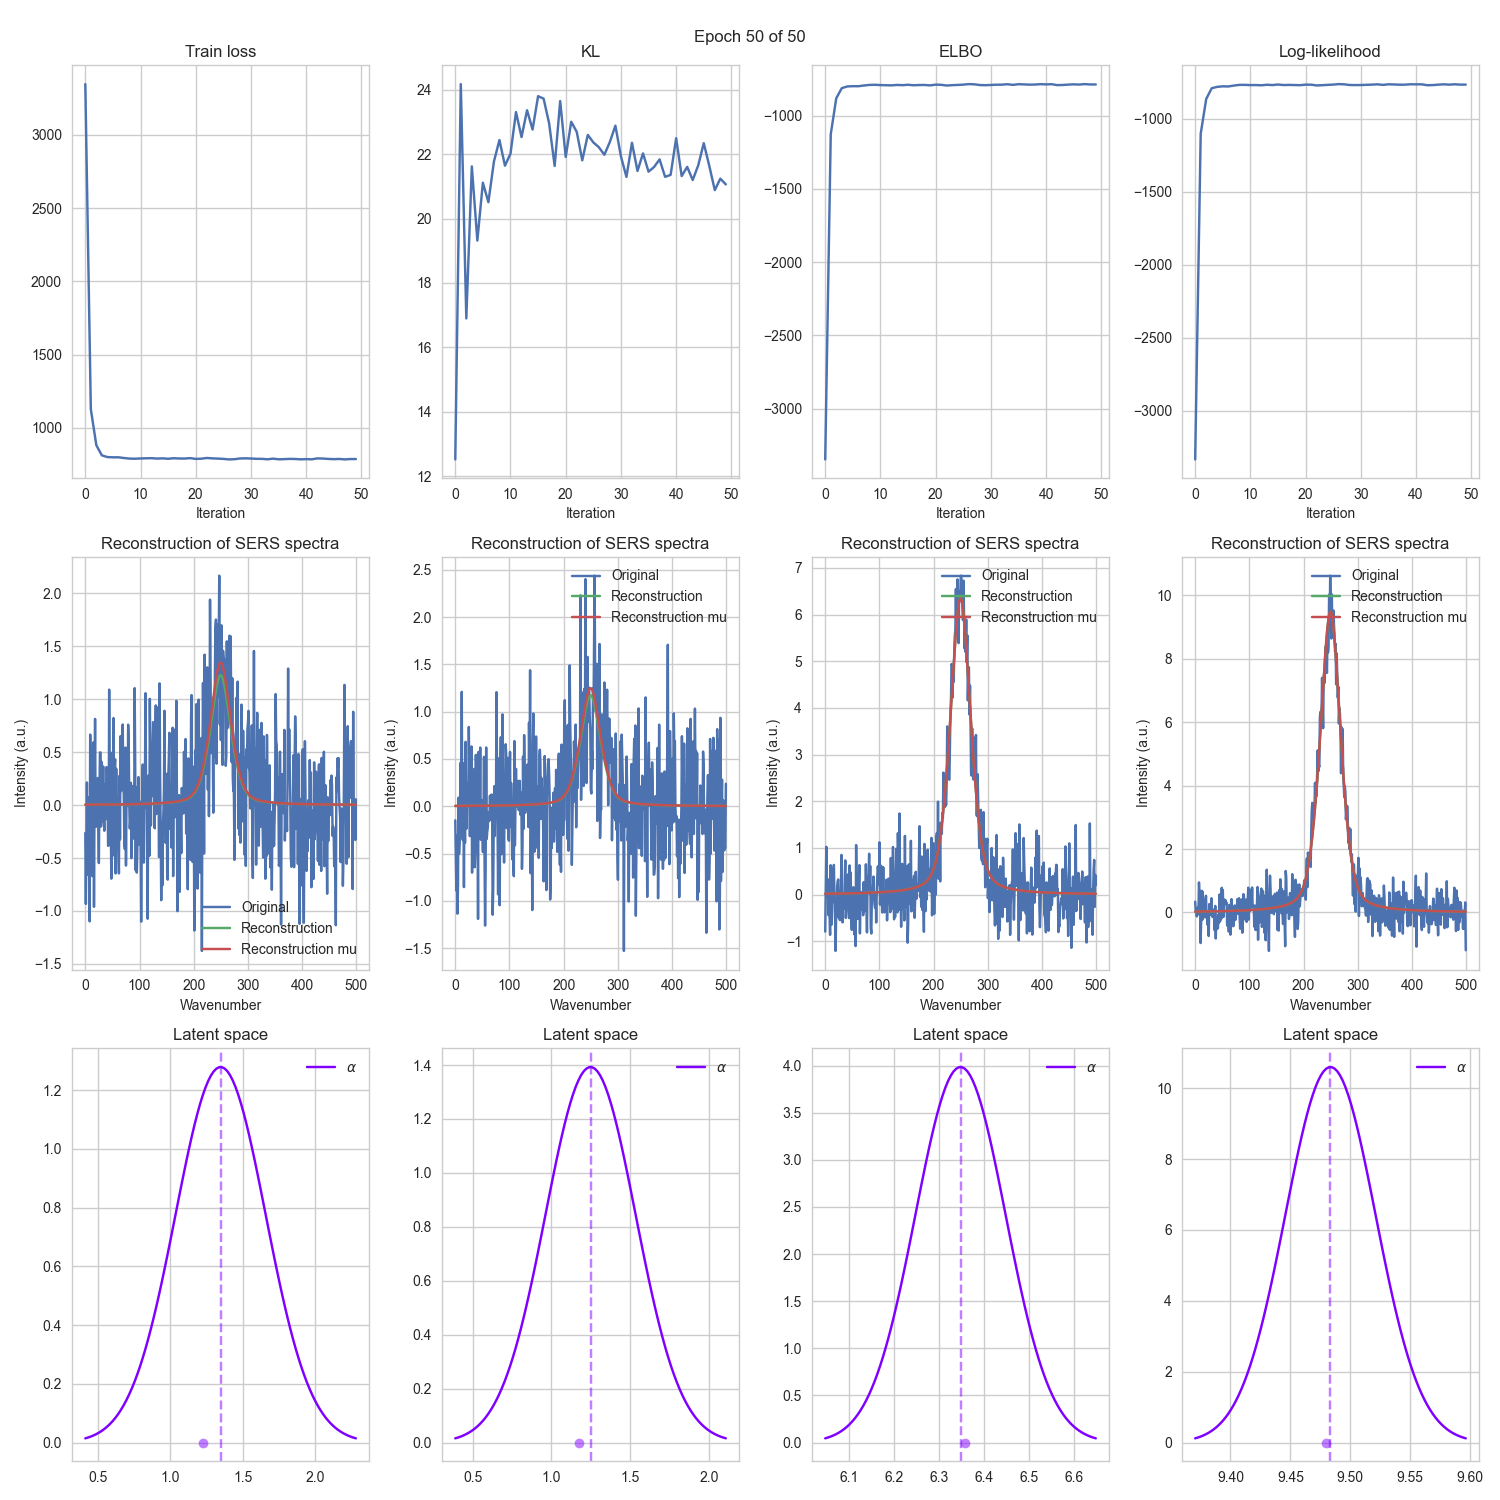

In [12]:
latent_dims = 1
num_batches_per_epoch = 10
learning_rate = 1e-3
beta = 1
optimizer = "adam"
batch_size = 100

epochs = 50
ps = pseudoVoigtSimulatorTorch(500)
generator = ps.generator(1, peaks = torch.tensor([250]), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = (0.5,10), sigma = 0.5)

dset_train = IterDataset(generator)
dset_test = IterDataset(generator)

# Load the SERS dataset
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=batch_size, pin_memory=cuda)

autoencoder = VAE(next(iter(train_loader))[0][1].shape, latent_dims, batch_size, "alpha").to(device) 

#==============================================================================
# Train the model
#==============================================================================

autoencoder, train_loss = train(autoencoder, train_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate,beta=beta, label = "alpha")

In [58]:
x , y = next(iter(train_loader))
x = x.to(device)
z, mu, logvar = autoencoder.encode(x)
x_hat = autoencoder.decode(z)
x_hat_mu = autoencoder.decode(mu)
sigma = torch.exp(0.5*logvar)
z = z.to('cpu').detach().numpy()
mu = mu.to('cpu').detach().numpy()
sigma = sigma.to('cpu').detach().numpy()

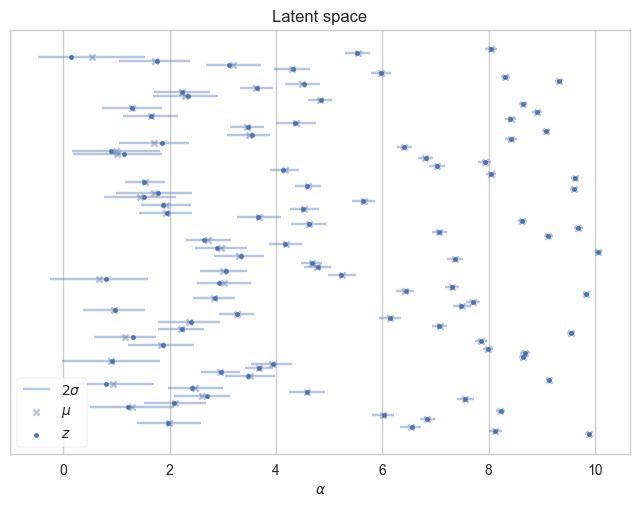

In [62]:
if z.shape[1] == 1: 
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    # randomize color order
    # np.random.shuffle(colors)
    # Make spacing between points on y-axis
    y_ = np.linspace(0, 1, z.shape[0])
    # make horizontal lines 2*sigma above and below the mean
    plt.hlines(y_, mu[:,0]-2*sigma[:,0], mu[:,0]+2*sigma[:,0], color=colors[0], alpha=0.4, label = "$2\\sigma$")
    # plot mu with marker x
    plt.scatter(mu[:,0], y_, color=colors[0], s=20, marker="x", alpha = 0.4, label = "$\\mu$")
    plt.scatter(z[:,0], y_, color=colors[0], s=10, marker="o", label = "$z$")

    plt.legend()
    # give legen a box frame
    plt.gca().legend(frameon=True)
    
    # make y-axis taller
    # remove ticks on y axis
    plt.yticks([])
    # SET LABEL FOR X AXIS
    text_cbar = f'$\\alpha$'

    plt.xlabel(text_cbar)

    plt.title("Latent space")
    plt.show()



Text(0, 0.5, '$\\sigma$')

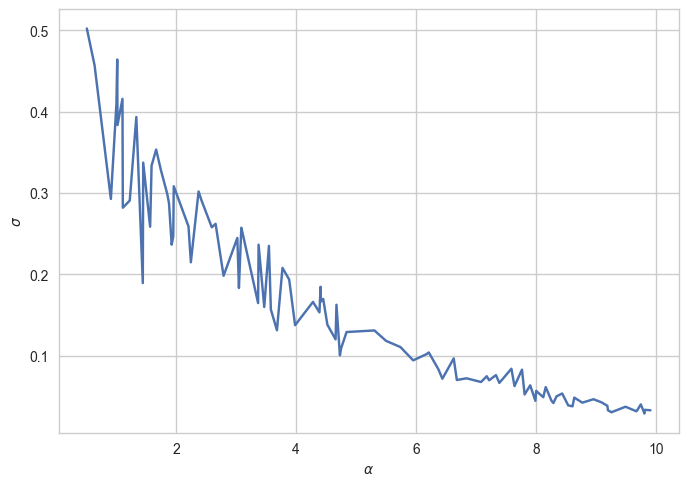

In [61]:
alpha = y[:,3].to('cpu').detach().numpy()
alpha = alpha.flatten()
sort = np.argsort(alpha)
z_ = z[sort]
mu_ = mu[sort]
sigma1 = sigma[:,0].flatten()
# sigma2 = sigma[:,1].flatten()
# print(sigma1.shape, sigma2.shape)
sigma1 = sigma1[sort]
alpha = alpha[sort]

# sigma[:,0]

plt.plot(alpha, sigma1, '-')
# plt.plot(alpha, sigma[:,1], '-')

# axes 
plt.xlabel('$\\alpha$')
plt.ylabel('$\\sigma$')


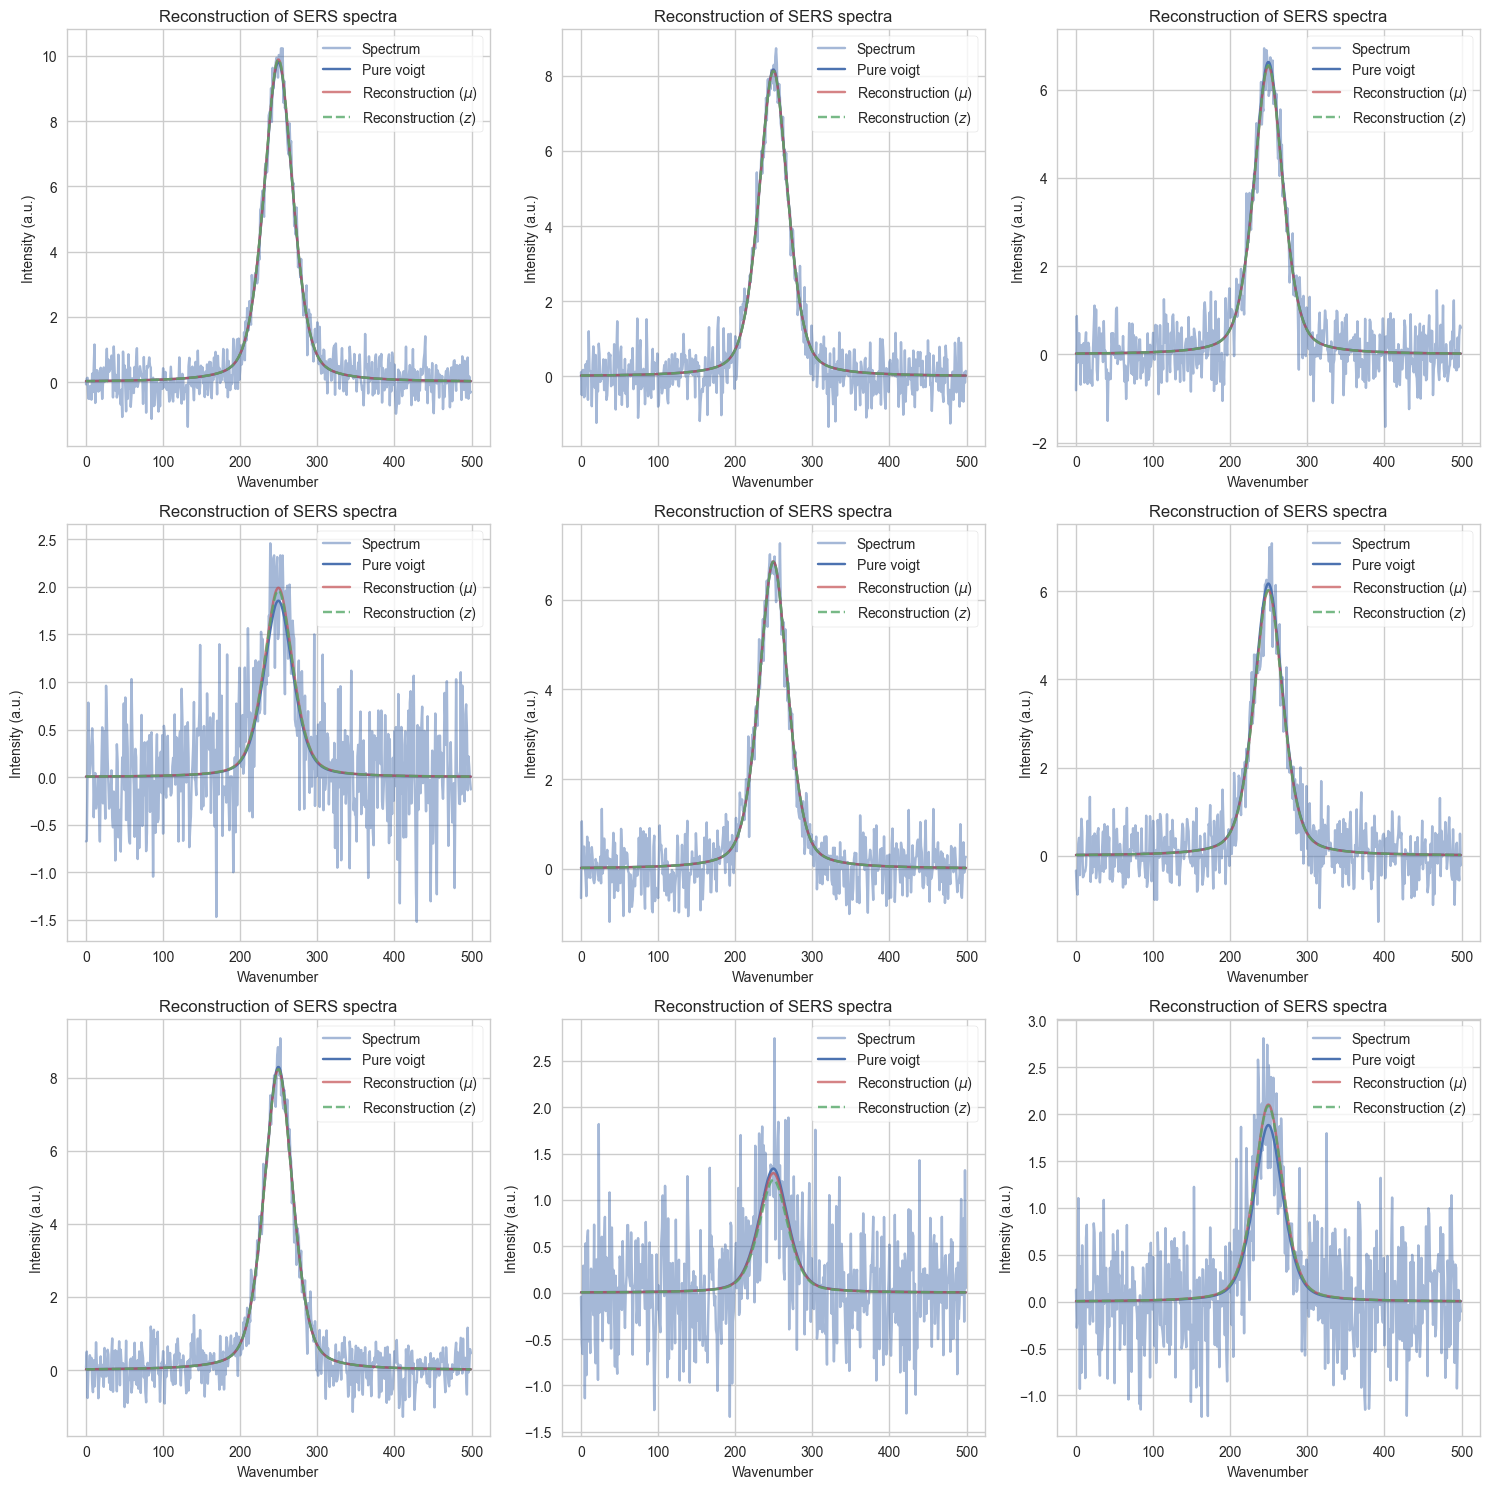

In [64]:
ps = pseudoVoigtSimulatorTorch(500)

def full_spec(x):
    return ps.generate_full_spectrum(peaks = torch.tensor([250]), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = x, sigma = 0, height_normalize=True, wavenumber_normalize=True)

x_ = x.to('cpu').detach().numpy()
x_hat_ = x_hat.to('cpu').detach().numpy()
x_hat_mu_ = x_hat_mu.to('cpu').detach().numpy()

plt_reconstructions(x_, x_hat_, x_hat_mu_, y[:,3], 3, full_spec)

# Varying $c$

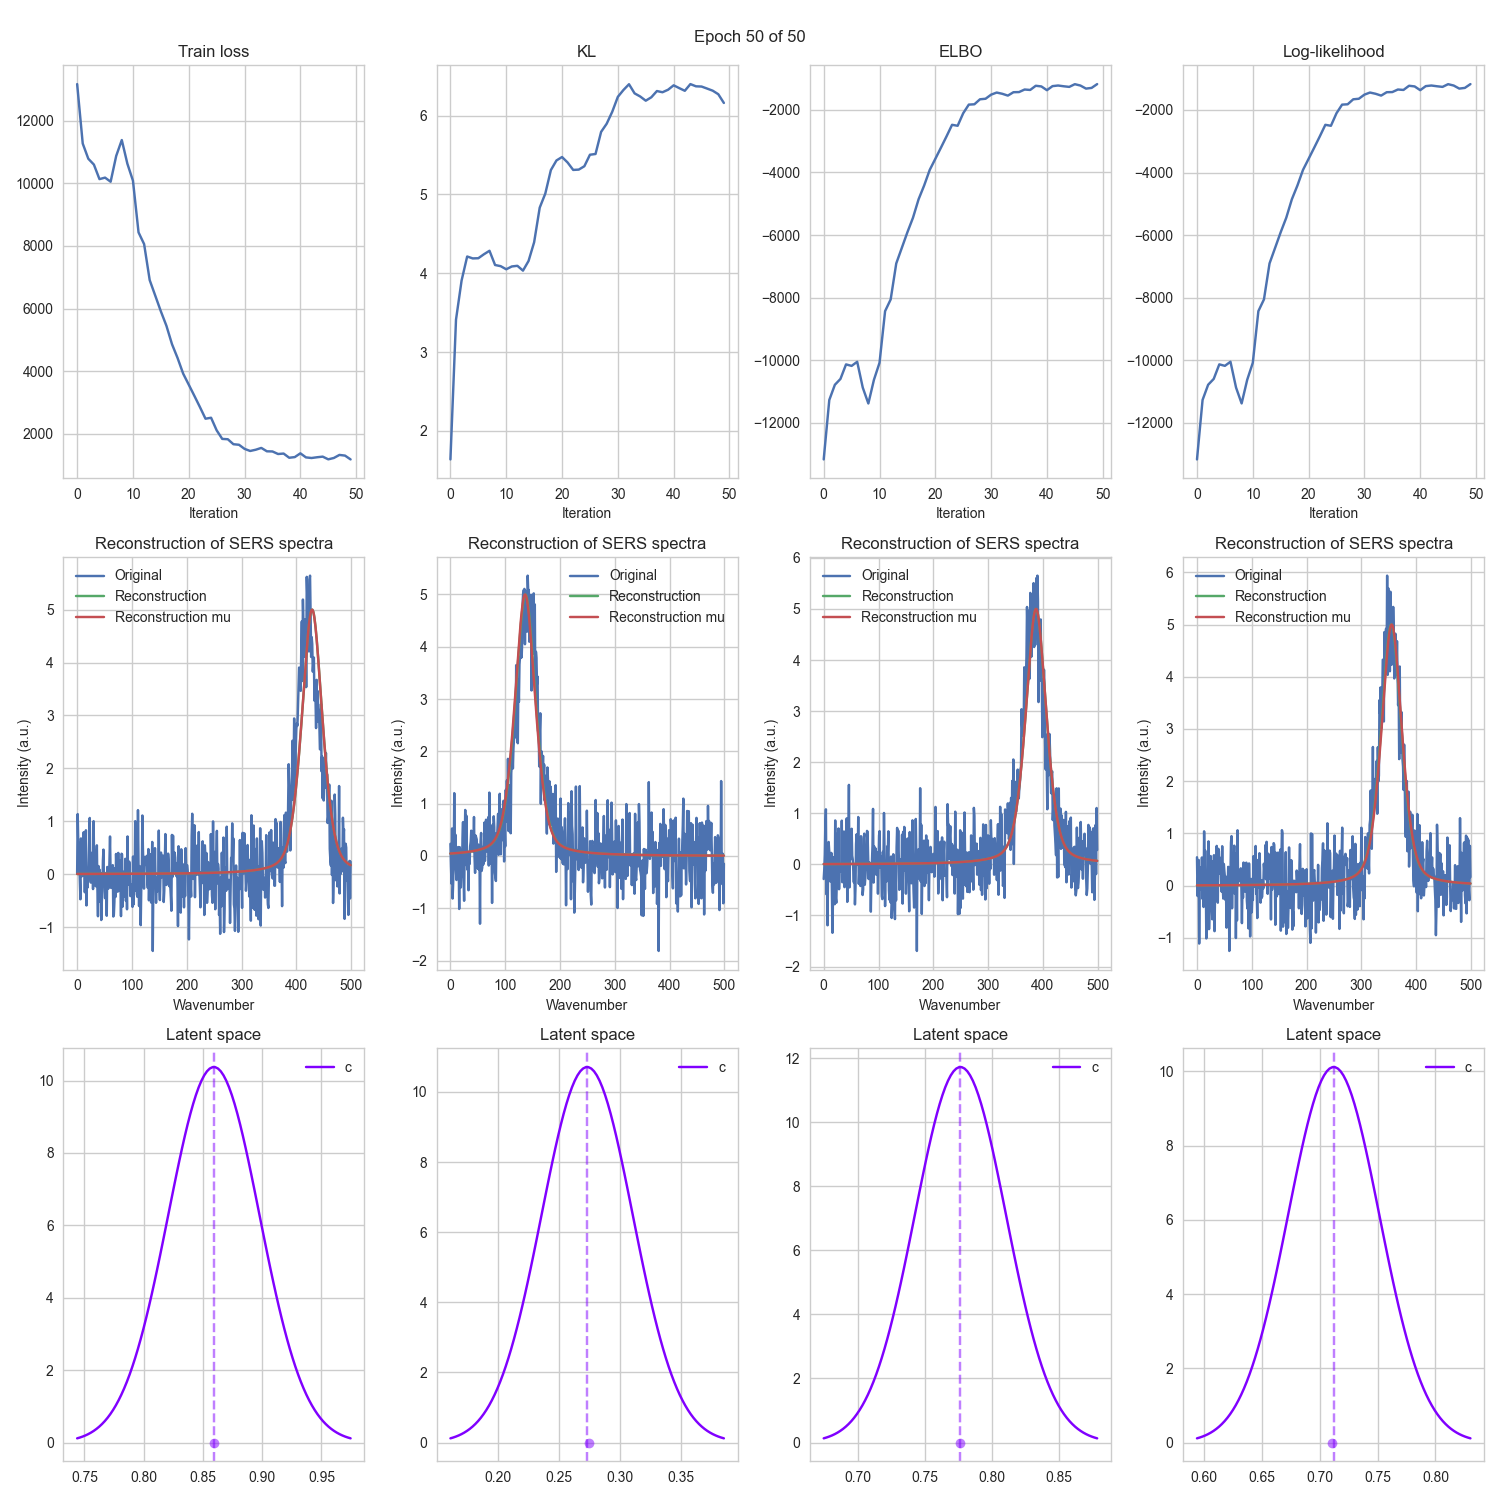

In [66]:
latent_dims = 1
num_batches_per_epoch = 10
learning_rate = 1e-3
beta = 1
optimizer = "adam"
batch_size = 100

epochs = 50
ps = pseudoVoigtSimulatorTorch(500)
generator = ps.generator(1, peaks = (50,450), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = torch.tensor([5]), sigma = 0.5)

dset_train = IterDataset(generator)
dset_test = IterDataset(generator)

# Load the SERS dataset
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=batch_size, pin_memory=cuda)

autoencoder = VAE(next(iter(train_loader))[0][1].shape, latent_dims, batch_size, "c").to(device) 

#==============================================================================
# Train the model
#==============================================================================

autoencoder, train_loss = train(autoencoder, train_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate,beta=beta, label = "c")

In [67]:
x , y = next(iter(train_loader))
x = x.to(device)
z, mu, logvar = autoencoder.encode(x)
x_hat = autoencoder.decode(z)
x_hat_mu = autoencoder.decode(mu)
sigma = torch.exp(0.5*logvar)
z = z.to('cpu').detach().numpy()
mu = mu.to('cpu').detach().numpy()
sigma = sigma.to('cpu').detach().numpy()

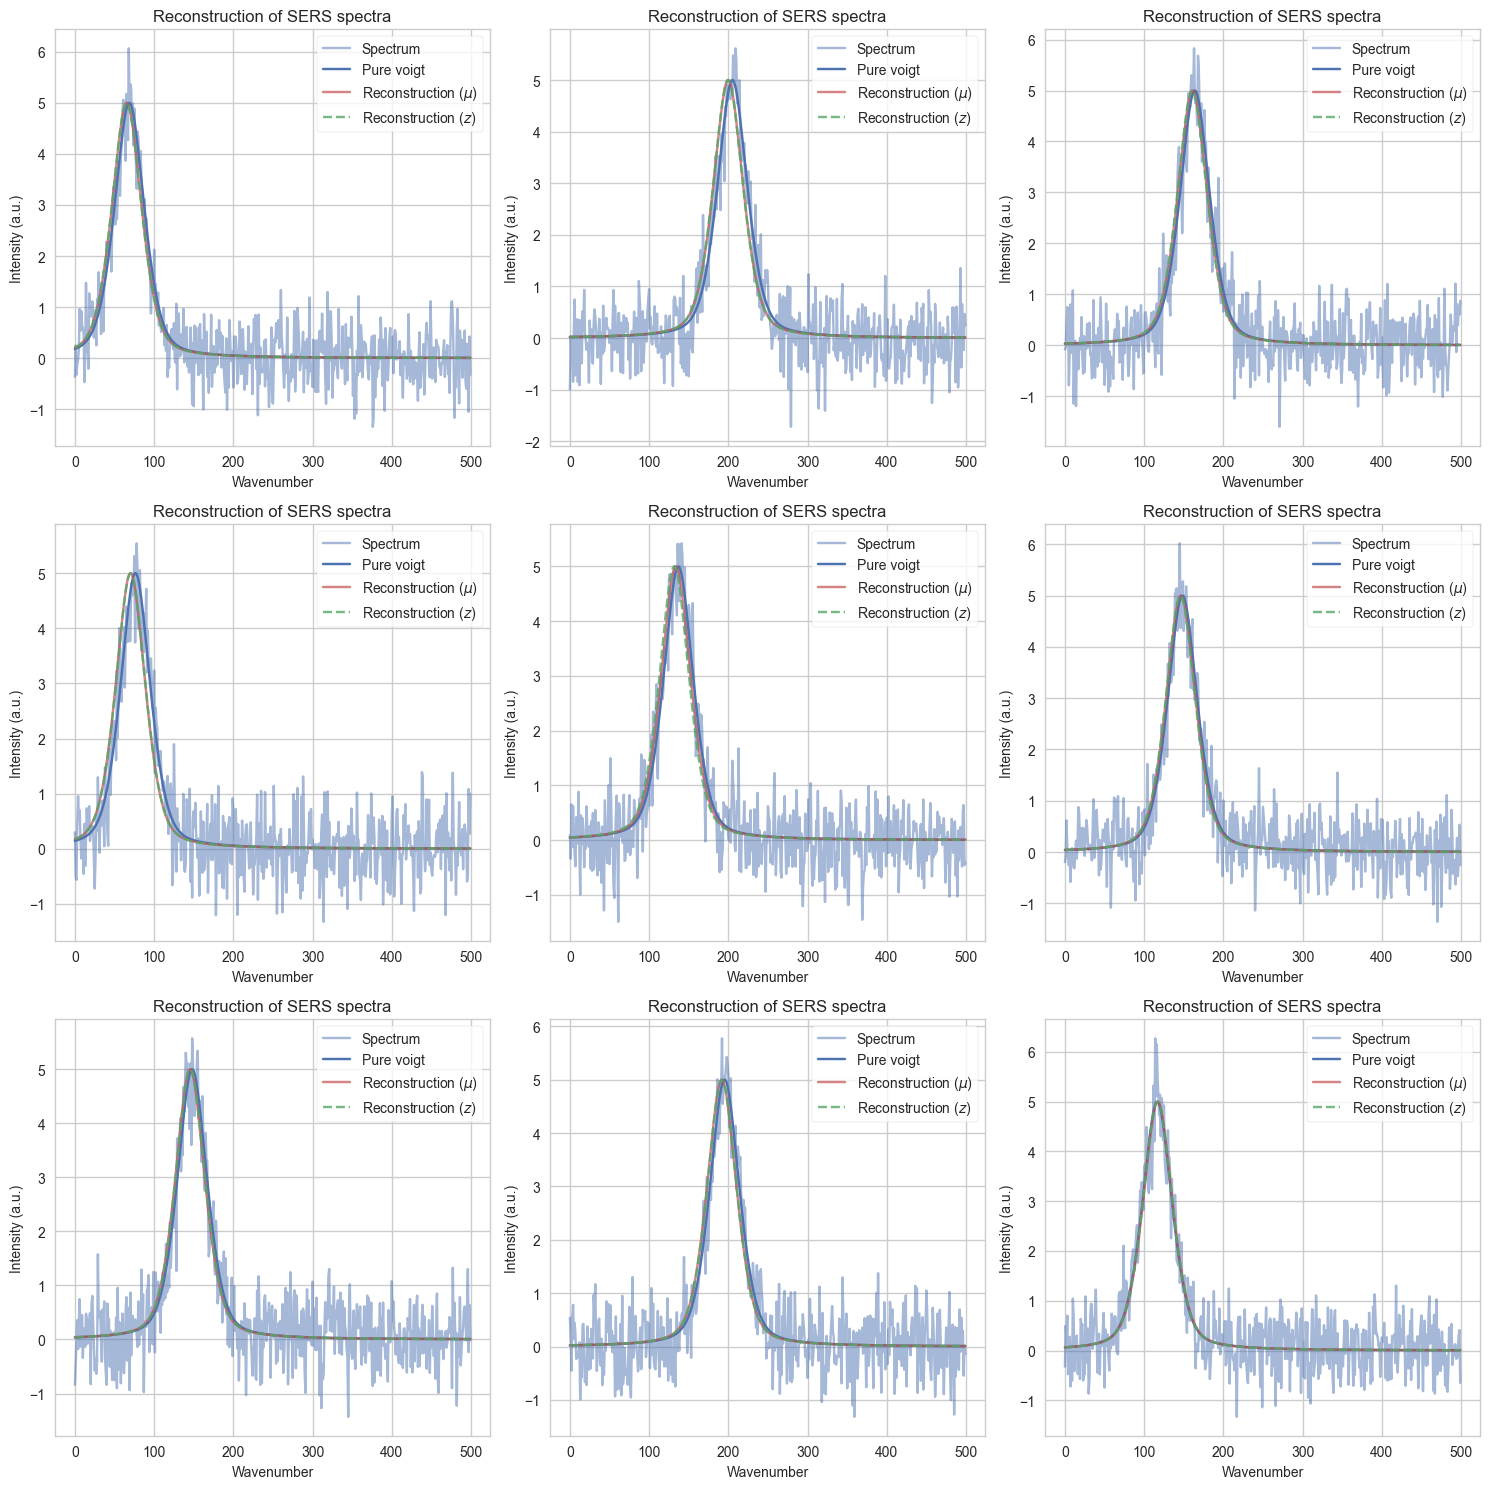

In [71]:
ps = pseudoVoigtSimulatorTorch(500)

def full_spec(x):
    return ps.generate_full_spectrum(peaks = x, gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = torch.tensor([5]), sigma = 0, height_normalize=True, wavenumber_normalize=True)

x_ = x.to('cpu').detach().numpy()
x_hat_ = x_hat.to('cpu').detach().numpy()
x_hat_mu_ = x_hat_mu.to('cpu').detach().numpy()

plt_reconstructions(x_, x_hat_, x_hat_mu_, y[:,0], 3, full_spec)

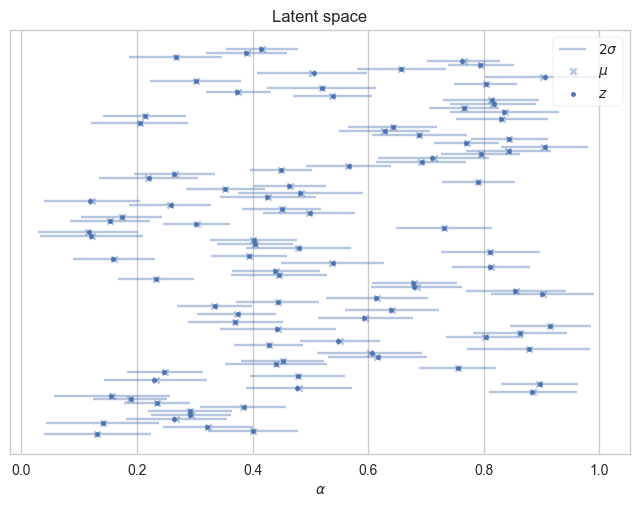

In [72]:
if z.shape[1] == 1: 
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    # randomize color order
    # np.random.shuffle(colors)
    # Make spacing between points on y-axis
    y_ = np.linspace(0, 1, z.shape[0])
    # make horizontal lines 2*sigma above and below the mean
    plt.hlines(y_, mu[:,0]-2*sigma[:,0], mu[:,0]+2*sigma[:,0], color=colors[0], alpha=0.4, label = "$2\\sigma$")
    # plot mu with marker x
    plt.scatter(mu[:,0], y_, color=colors[0], s=20, marker="x", alpha = 0.4, label = "$\\mu$")
    plt.scatter(z[:,0], y_, color=colors[0], s=10, marker="o", label = "$z$")

    plt.legend()
    # give legen a box frame
    plt.gca().legend(frameon=True)
    
    # make y-axis taller
    # remove ticks on y axis
    plt.yticks([])
    # SET LABEL FOR X AXIS
    text_cbar = f'$\\alpha$'

    plt.xlabel(text_cbar)

    plt.title("Latent space")
    plt.show()



Text(0, 0.5, '$\\sigma$')

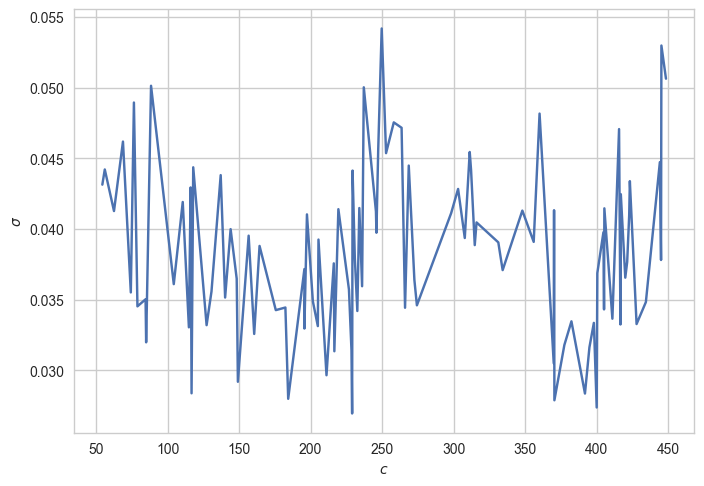

In [76]:
c = y[:,0].to('cpu').detach().numpy()
c = c.flatten()
sort = np.argsort(c)
z_ = z[sort]
mu_ = mu[sort]
sigma1 = sigma[:,0].flatten()
# sigma2 = sigma[:,1].flatten()
# print(sigma1.shape, sigma2.shape)
sigma1 = sigma1[sort]
c = c[sort]

# sigma[:,0]

plt.plot(c, sigma1, '-')
# plt.plot(alpha, sigma[:,1], '-')

# axes 
plt.xlabel('$c$')
plt.ylabel('$\\sigma$')


# Both $\alpha$ and $c$

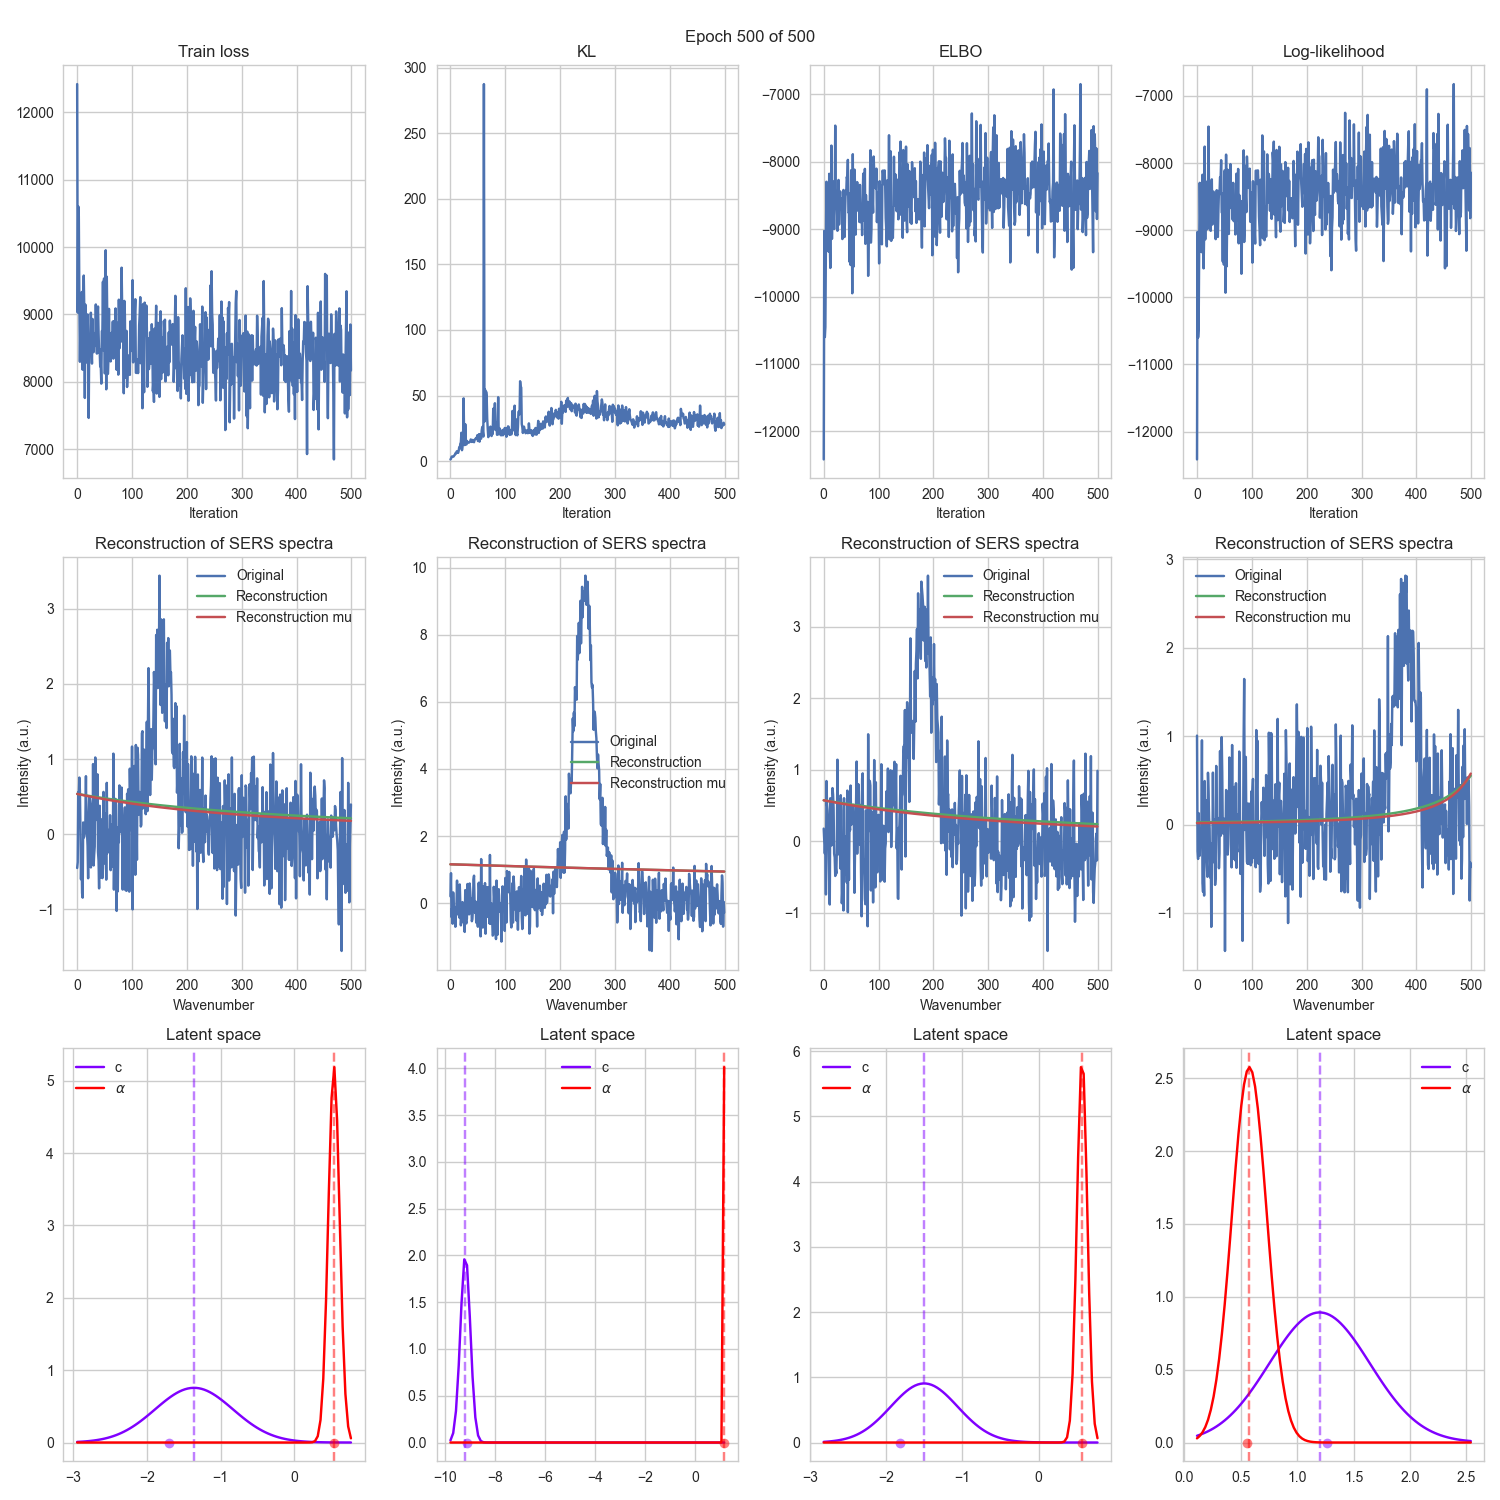

In [87]:
latent_dims = 2
num_batches_per_epoch = 1
learning_rate = 1e-3
beta = 1
optimizer = "adam"
batch_size = 100
epochs = 500

ps = pseudoVoigtSimulatorTorch(500)
generator = ps.generator(1, peaks = (50, 450), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = (0.5,10), sigma = 0.25)

dset_train = IterDataset(generator)
dset_test = IterDataset(generator)

# Load the SERS dataset
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=batch_size, pin_memory=cuda)

autoencoder = VAE_TwoParams(next(iter(train_loader))[0][1].shape, latent_dims, batch_size, ["c", "alpha"]).to(device) 

#==============================================================================
# Train the model
#==============================================================================

autoencoder, train_loss = train(autoencoder, train_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate,beta=beta, label = ["c", "alpha"])

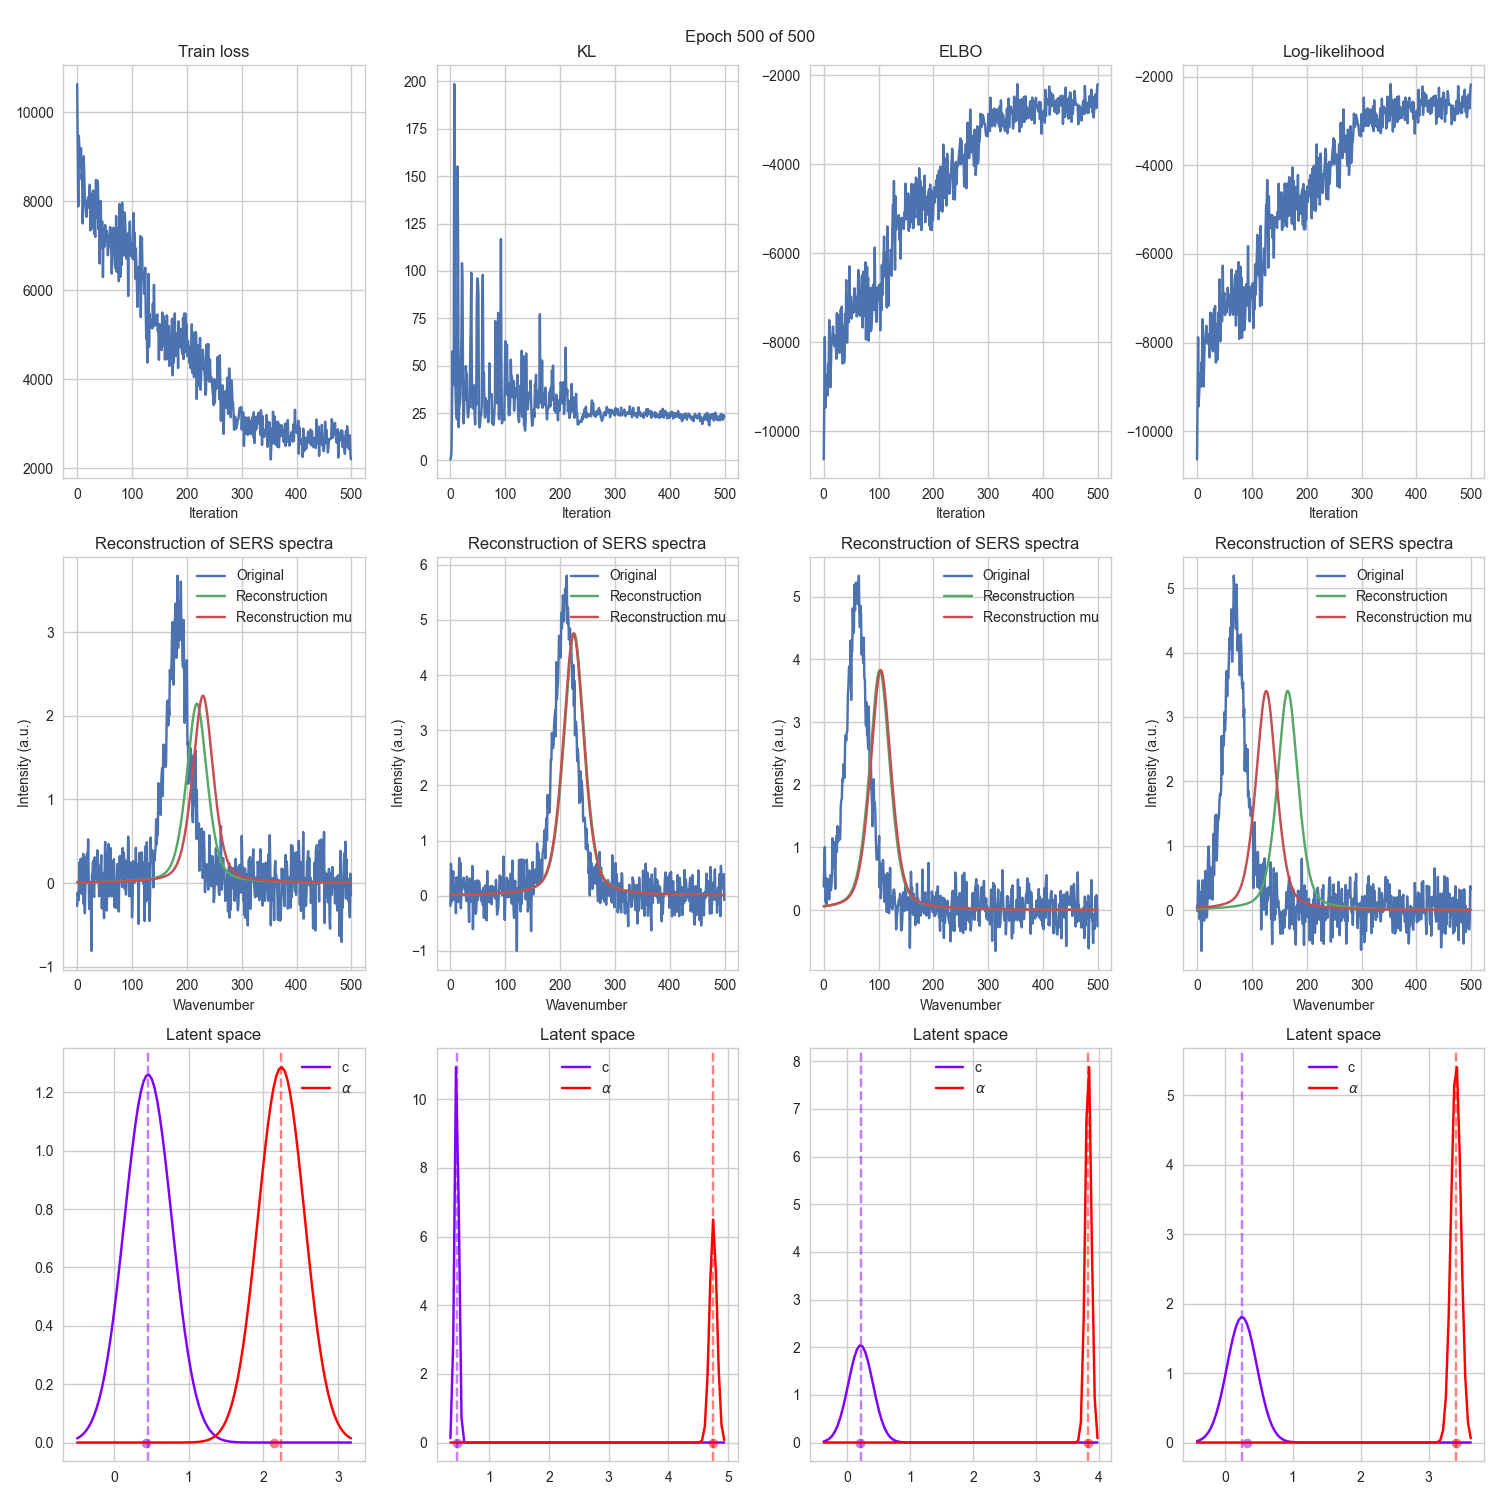

In [156]:
latent_dims = 2
num_batches_per_epoch = 1
learning_rate = 1e-3
beta = 1
optimizer = "adam"
batch_size = 100
epochs = 500

ps = pseudoVoigtSimulatorTorch(500)
generator = ps.generator(1, peaks = (50, 450), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = (0.5,10), sigma = 0.25)

dset_train = IterDataset(generator)
dset_test = IterDataset(generator)

# Load the SERS dataset
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=batch_size, pin_memory=cuda)

autoencoder = VAE_TwoParamsSigmoid(next(iter(train_loader))[0][1].shape, latent_dims, batch_size, ["c", "alpha"]).to(device) 

#==============================================================================
# Train the model
#==============================================================================

autoencoder, train_loss = train(autoencoder, train_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate,beta=beta, label = ["c", "alpha"])

In [160]:
x , y = next(iter(train_loader))
x = x.to(device)
z, mu, logvar = autoencoder.encode(x)
x_hat = autoencoder.decode(z)
x_hat_mu = autoencoder.decode(mu)
sigma = torch.exp(0.5*logvar)
z = z.to('cpu').detach().numpy()
mu = mu.to('cpu').detach().numpy()
sigma = sigma.to('cpu').detach().numpy()

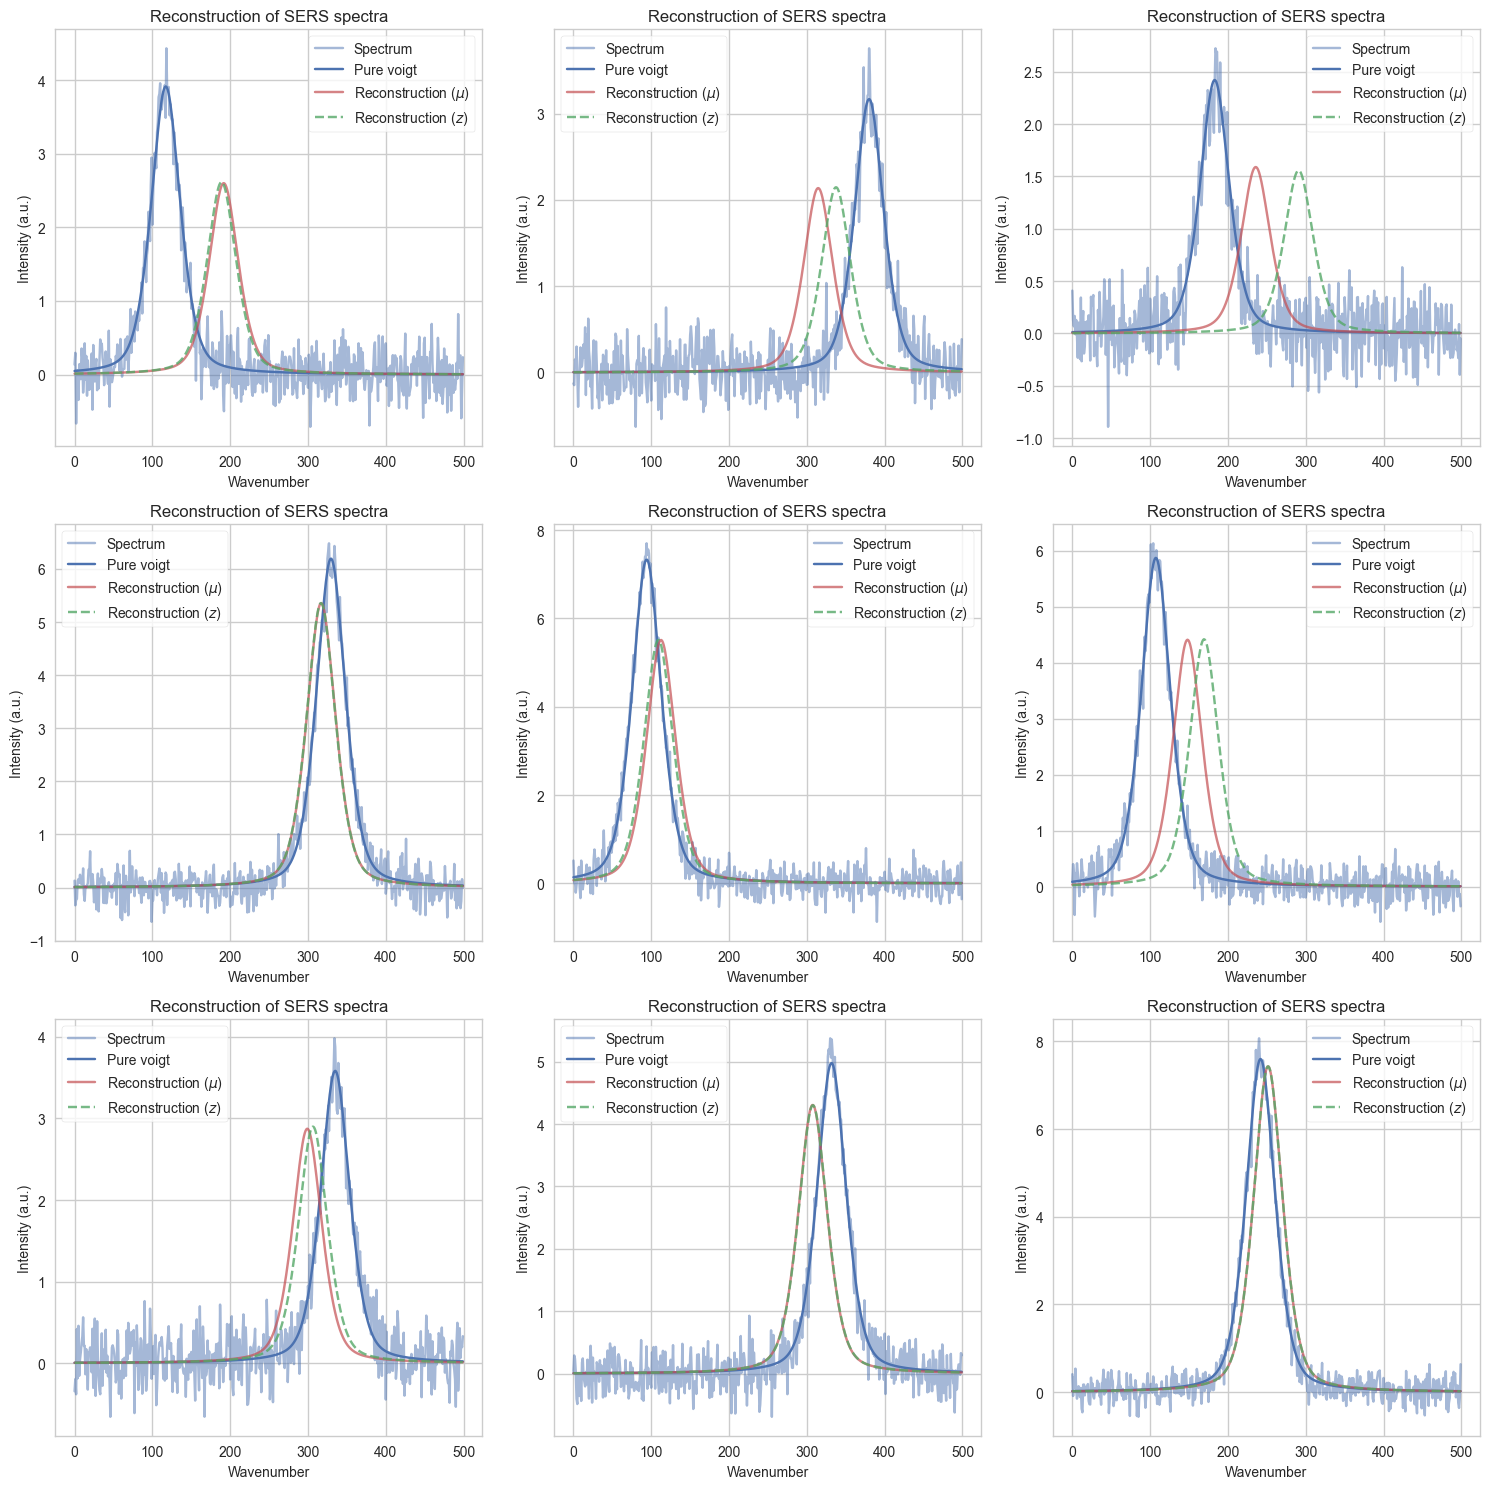

In [165]:
ps = pseudoVoigtSimulatorTorch(500)

def full_spec(x,y):
    return ps.generate_full_spectrum(peaks = x, gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = y, sigma = 0, height_normalize=True, wavenumber_normalize=True)

x_ = x.to('cpu').detach().numpy()
x_hat_ = x_hat.to('cpu').detach().numpy()
x_hat_mu_ = x_hat_mu.to('cpu').detach().numpy()

plt_reconstructions(x_, x_hat_, x_hat_mu_, y, full_spec, n=3)

C:\Users\andre\AppData\Local\Temp\ipykernel_9492\826839679.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mu_[:,i], y_, color=colors,cmap="viridis", s=20, marker="x", alpha = 0.4, label = "$\\mu$")
C:\Users\andre\AppData\Local\Temp\ipykernel_9492\826839679.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z_[:,i], y_, color=colors, cmap="viridis", s=10, marker="o", label = "$z$")
C:\Users\andre\AppData\Local\Temp\ipykernel_9492\826839679.py:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mappable, label=f"$\\sigma_{dict_[i]}$")


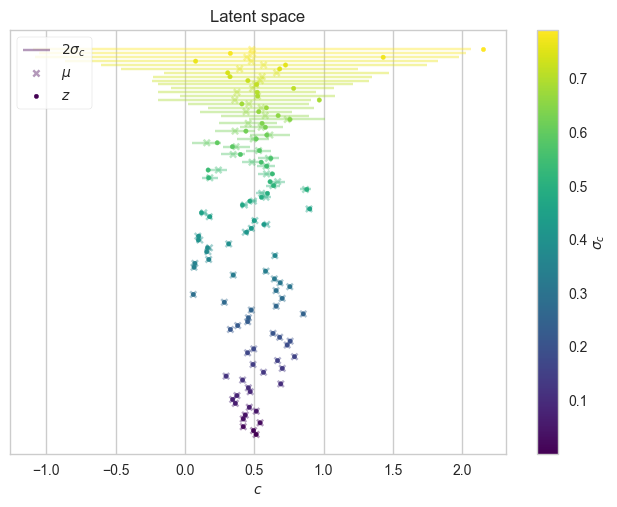

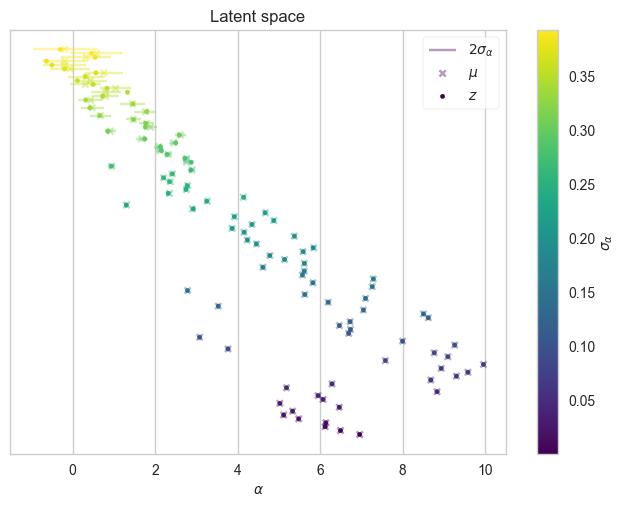

In [144]:

dict_ = {0: "c", 1: "\\alpha"}

for i in range(2):

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    # sort by sigma 
    idx = np.argsort(sigma[:,i])
    z_ = z[idx]
    mu_ = mu[idx]
    sigma_ = sigma[idx]

    # colors vidris color map
    colors = plt.cm.viridis(np.linspace(0, 1, len(z_[:,i])))

    # randomize color order
    # np.random.shuffle(colors)
    # Make spacing between points on y-axis
    y_ = np.linspace(0, 1, z_.shape[0])
    # make horizontal lines 2*sigma above and below the mean
    plt.hlines(y_, mu_[:,i]-2*sigma_[:,i], mu_[:,i]+2*sigma_[:,i], color=colors, 
               cmap="viridis", alpha=0.4, label = f"$2\\sigma_{dict_[i]}$")
    # plot mu with marker x
    plt.scatter(mu_[:,i], y_, color=colors,cmap="viridis", s=20, marker="x", alpha = 0.4, label = "$\\mu$")
    plt.scatter(z_[:,i], y_, color=colors, cmap="viridis", s=10, marker="o", label = "$z$")


    # colorbar 
    # create a ScalarMappable and initialize a data structure
    mappable = plt.cm.ScalarMappable(cmap="viridis")
    mappable.set_array(sigma_[:,i])
    mappable.set_clim(min(sigma_[:,i]), max(sigma_[:,i]))
    plt.colorbar(mappable, label=f"$\\sigma_{dict_[i]}$")

    plt.legend()
    # give legen a box frame
    plt.gca().legend(frameon=True)

    # make y-axis taller
    # remove ticks on y axis
    plt.yticks([])
    # SET LABEL FOR X AXIS
    text_cbar = f"${dict_[i]}$"

    plt.xlabel(text_cbar)

    plt.title("Latent space")
    plt.show()



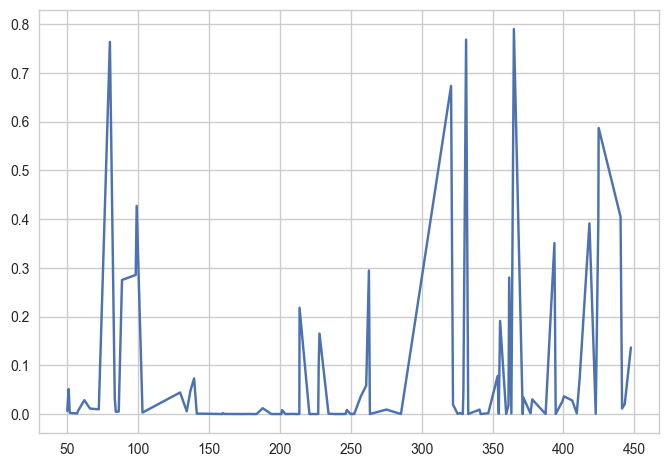

In [140]:
c = y[:,0].to('cpu').detach().numpy()
c = c.flatten()
sort = np.argsort(c)
z_ = z[sort]s
mu_ = mu[sort]
sigma1 = sigma[:,0].flatten()
# sigma2 = sigma[:,1].flatten()
# print(sigma1.shape, sigma2.shape)
sigma1 = sigma1[sort]
c = c[sort]

# sigma[:,0]

plt.plot(c, sigma1, '-')
# plt.plot(alpha, sigma[:,1], '-')


Text(0, 0.5, '$\\sigma$')

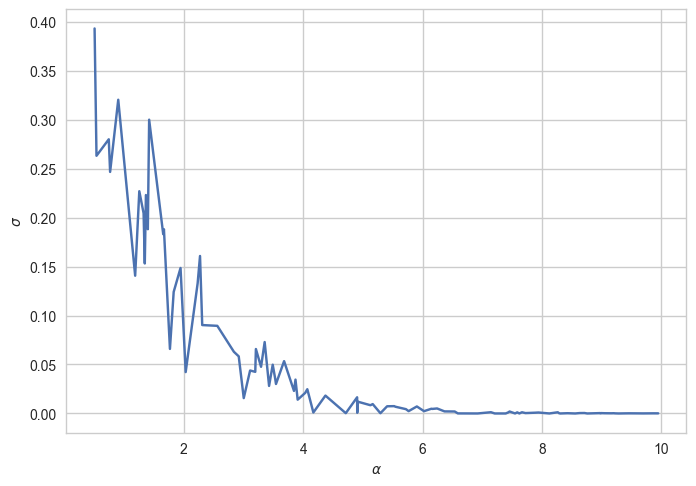

In [142]:

# axes 
plt.xlabel('$\\alpha$')
plt.ylabel('$\\sigma$')

alpha = y[:,3].to('cpu').detach().numpy()
alpha = alpha.flatten()
sort = np.argsort(alpha)
z_ = z[sort]
mu_ = mu[sort]
sigma1 = sigma[:,1].flatten()
# sigma2 = sigma[:,1].flatten()
# print(sigma1.shape, sigma2.shape)
sigma1 = sigma1[sort]
alpha = alpha[sort]

# sigma[:,0]

plt.plot(alpha, sigma1, '-')
# plt.plot(alpha, sigma[:,1], '-')

# axes 
plt.xlabel('$\\alpha$')
plt.ylabel('$\\sigma$')

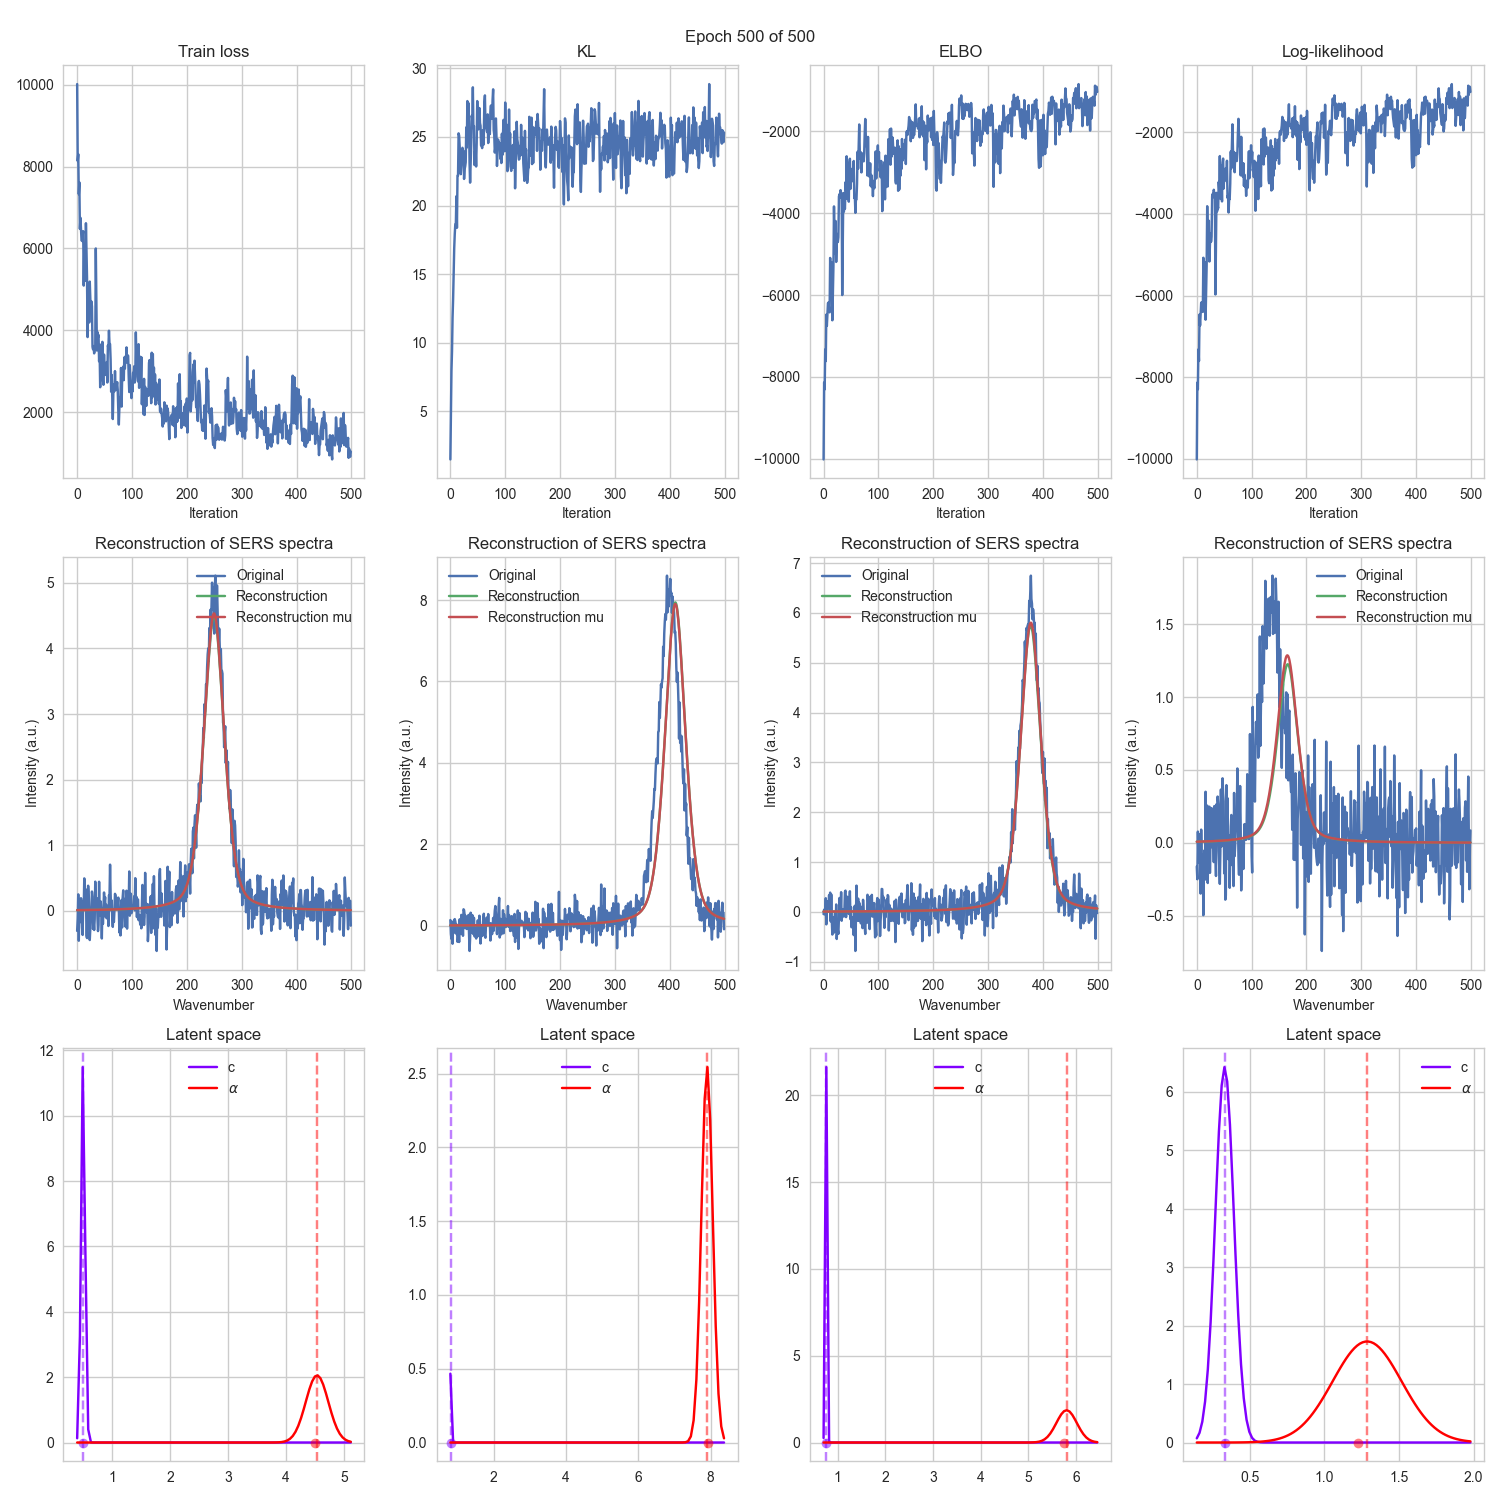

In [150]:
latent_dims = 2
num_batches_per_epoch = 1
learning_rate = 1e-4
beta = 1
optimizer = "adam"
batch_size = 100
epochs = 500

ps = pseudoVoigtSimulatorTorch(500)
generator = ps.generator(1, peaks = (50, 450), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = (0.5,10), sigma = 0.25)

dset_train = IterDataset(generator)
dset_test = IterDataset(generator)

# Load the SERS dataset
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=batch_size, pin_memory=cuda)

autoencoder = VAE_TwoParamsSigmoidConv(next(iter(train_loader))[0][1].shape, latent_dims, batch_size, ["c", "alpha"]).to(device) 

#==============================================================================
# Train the model
#==============================================================================

autoencoder, train_loss = train(autoencoder, train_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate,beta=beta, label = ["c", "alpha"])

In [152]:
x , y = next(iter(train_loader))
x = x.to(device)
z, mu, logvar = autoencoder.encode(x)
x_hat = autoencoder.decode(z)
x_hat_mu = autoencoder.decode(mu)
sigma = torch.exp(0.5*logvar)
z = z.to('cpu').detach().numpy()
mu = mu.to('cpu').detach().numpy()
sigma = sigma.to('cpu').detach().numpy()

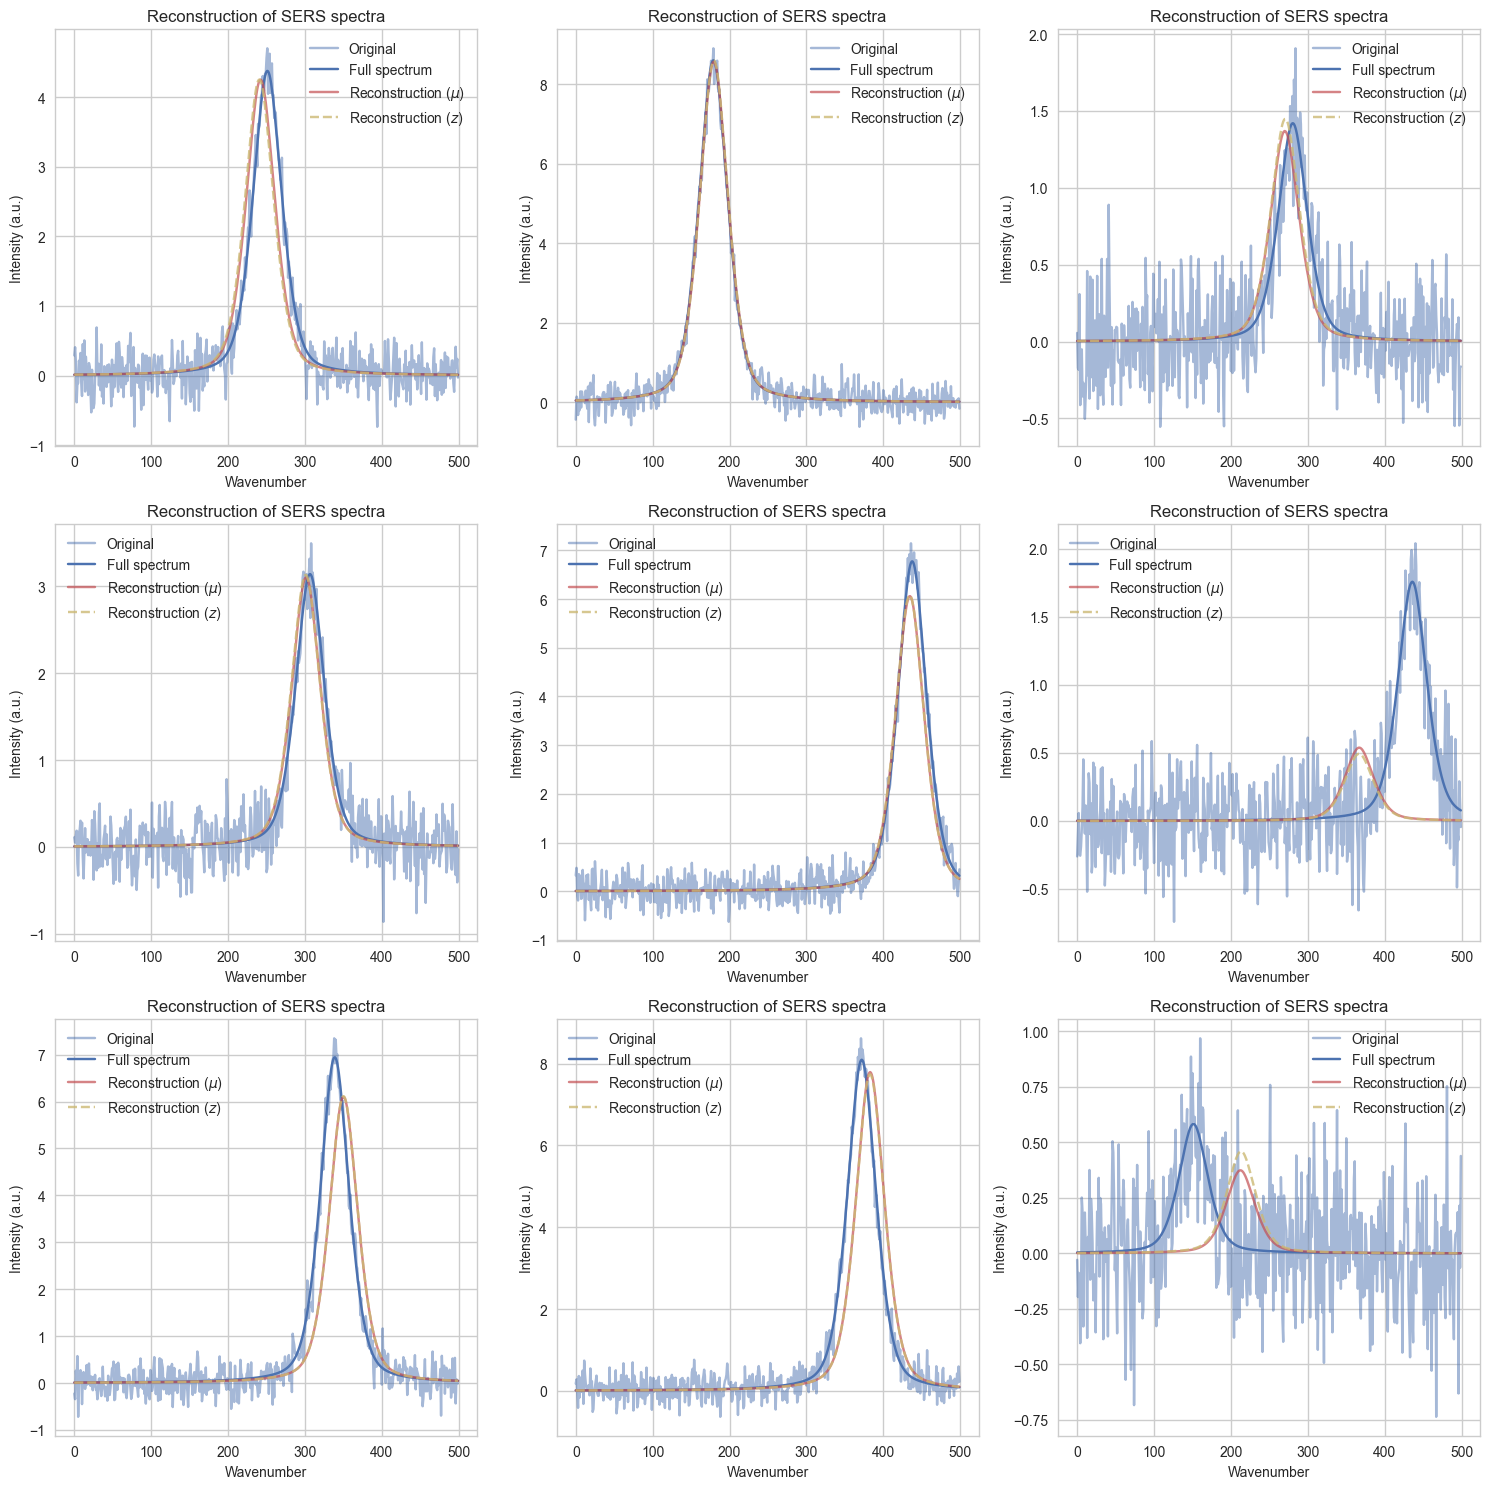

In [153]:
x, y = next(iter(test_loader))
x = x.to(device)

ps = pseudoVoigtSimulatorTorch(500)

def full_spec(x,y):
    return ps.generate_full_spectrum(peaks = x, gamma = torch.tensor([20]), eta = torch.tensor([0.5]), 
                                     alpha = y, sigma = 0, height_normalize=True, wavenumber_normalize=True)

# get default colors    
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
print()

with torch.no_grad():
    autoencoder.eval()
    z, mu, logvar = autoencoder.encode(x)
    sigma = torch.exp(logvar)
    x_hat = autoencoder.decode(z)
    x_hat_mu = autoencoder.decode(mu)

    n= 3
    fig, axs = plt.subplots(n, n, figsize=(15,15))
    for i in range(n*n):
        axs[i//n, i%n].plot(x[i].flatten(), label="Original", alpha=0.5, color=colors[0])
        axs[i//n, i%n].plot(full_spec(y[:,0][i], y[:,3][i]).flatten(), label="Full spectrum", color=colors[0])
        axs[i//n, i%n].plot(x_hat_mu[i].flatten(), label="Reconstruction ($\\mu$)", alpha=0.7, color=colors[2])
        axs[i//n, i%n].plot(x_hat[i].flatten(), label="Reconstruction ($z$)", alpha=0.8, color=colors[4], linestyle="--")
        axs[i//n, i%n].set_title("Reconstruction of SERS spectra")
        axs[i//n, i%n].set_xlabel("Wavenumber")
        axs[i//n, i%n].set_ylabel("Intensity (a.u.)")
        axs[i//n, i%n].legend()
    plt.tight_layout()
    plt.show()



C:\Users\andre\AppData\Local\Temp\ipykernel_9492\826839679.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mu_[:,i], y_, color=colors,cmap="viridis", s=20, marker="x", alpha = 0.4, label = "$\\mu$")
C:\Users\andre\AppData\Local\Temp\ipykernel_9492\826839679.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z_[:,i], y_, color=colors, cmap="viridis", s=10, marker="o", label = "$z$")
C:\Users\andre\AppData\Local\Temp\ipykernel_9492\826839679.py:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mappable, label=f"$\\sigma_{dict_[i]}$")


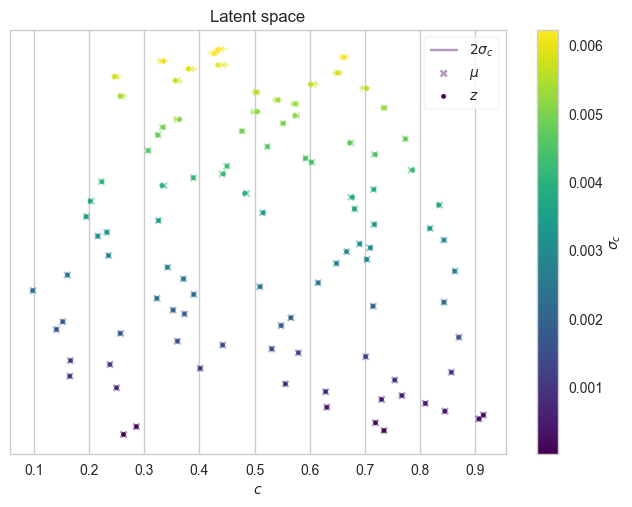

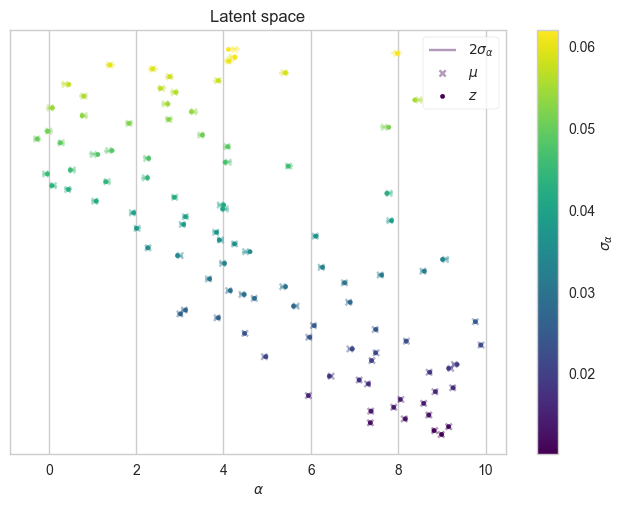

In [154]:

dict_ = {0: "c", 1: "\\alpha"}

for i in range(2):

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    # sort by sigma 
    idx = np.argsort(sigma[:,i])
    z_ = z[idx]
    mu_ = mu[idx]
    sigma_ = sigma[idx]

    # colors vidris color map
    colors = plt.cm.viridis(np.linspace(0, 1, len(z_[:,i])))

    # randomize color order
    # np.random.shuffle(colors)
    # Make spacing between points on y-axis
    y_ = np.linspace(0, 1, z_.shape[0])
    # make horizontal lines 2*sigma above and below the mean
    plt.hlines(y_, mu_[:,i]-2*sigma_[:,i], mu_[:,i]+2*sigma_[:,i], color=colors, 
               cmap="viridis", alpha=0.4, label = f"$2\\sigma_{dict_[i]}$")
    # plot mu with marker x
    plt.scatter(mu_[:,i], y_, color=colors,cmap="viridis", s=20, marker="x", alpha = 0.4, label = "$\\mu$")
    plt.scatter(z_[:,i], y_, color=colors, cmap="viridis", s=10, marker="o", label = "$z$")


    # colorbar 
    # create a ScalarMappable and initialize a data structure
    mappable = plt.cm.ScalarMappable(cmap="viridis")
    mappable.set_array(sigma_[:,i])
    mappable.set_clim(min(sigma_[:,i]), max(sigma_[:,i]))
    plt.colorbar(mappable, label=f"$\\sigma_{dict_[i]}$")

    plt.legend()
    # give legen a box frame
    plt.gca().legend(frameon=True)

    # make y-axis taller
    # remove ticks on y axis
    plt.yticks([])
    # SET LABEL FOR X AXIS
    text_cbar = f"${dict_[i]}$"

    plt.xlabel(text_cbar)

    plt.title("Latent space")
    plt.show()



Text(0, 0.5, '$\\sigma$')

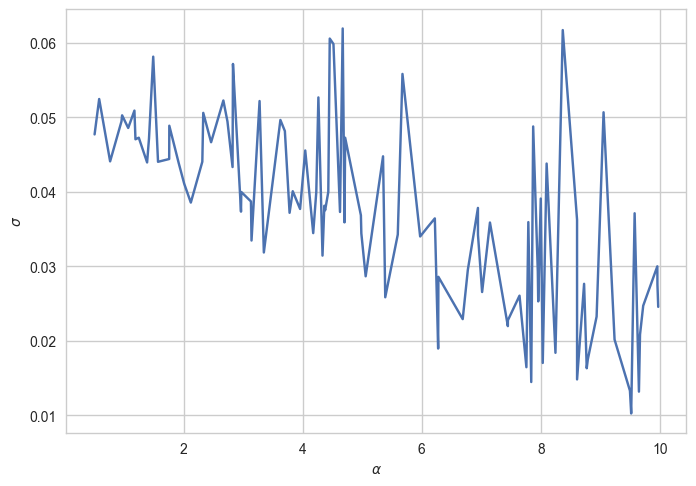

In [155]:

# axes 
plt.xlabel('$\\alpha$')
plt.ylabel('$\\sigma$')

alpha = y[:,3].to('cpu').detach().numpy()
alpha = alpha.flatten()
sort = np.argsort(alpha)
z_ = z[sort]
mu_ = mu[sort]
sigma1 = sigma[:,1].flatten()
# sigma2 = sigma[:,1].flatten()
# print(sigma1.shape, sigma2.shape)
sigma1 = sigma1[sort]
alpha = alpha[sort]

# sigma[:,0]

plt.plot(alpha, sigma1, '-')
# plt.plot(alpha, sigma[:,1], '-')

# axes 
plt.xlabel('$\\alpha$')
plt.ylabel('$\\sigma$')